# Extracting Book Metadata from Book Pages


In [14]:
%reload_ext autoreload
%autoreload 2


In [120]:
import os
import re

from parse import read_book_review_files

main_dir = '../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/Canonical_book_pages/'
html_dir = '../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/'


book_files = read_book_review_files(html_dir)



../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/Canonical_book_pages 2975046-a-daughter-s-a-daughter?from_search=true&from_srp=true&qid=EYhuLIe7qE&rank=1.html
../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/Canonical_book_pages 140345.Absent_in_the_Spring?from_search=true&from_srp=true&qid=VsMXCvsq4L&rank=1.html
../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/Canonical_book_pages 8574333-please-look-after-mom?from_search=true&from_srp=true&qid=HYWuLQYbEO&rank=1.html


In [121]:
book_ids = [book_id for book_id in book_files.keys()]
print('number of book IDs:', len(book_ids))

[book_id for book_id in book_ids if book_id.startswith('39')]

number of book IDs: 138


['39618887-the-plotters',
 '393199.Down_and_Out_in_Paris_and_London',
 '39988.Matilda']

## Extract Book Metadata and Reviews from Goodreads Book Pages

In [144]:
from parse import get_metadata_reviews


def map_html_to_json_file(html_filepath, json_base_dir):
    lang_dir, html_filename = os.path.split(html_filepath)
    json_filename = html_filename.replace('.html', '-reviews.json')
    _, lang = os.path.split(lang_dir)
    json_lang_dir = os.path.join(json_base_dir, lang)
    if os.path.exists(json_lang_dir) is False:
        os.mkdir(json_lang_dir)
    return os.path.join(json_lang_dir, json_filename)


json_base_dir = '../../data/reviews/Multilingual/Goodreads/JSON/'

book_metadata_file = '../../data/reviews/Multilingual/Goodreads/books-metadata.json'

#get_metadata_reviews(book_files)
for book_id in book_files:
    for html_file in book_files[book_id]:
        json_file = map_html_to_json_file(html_file, json_base_dir)
        print([book_id, bf, json_file])
    break

['32940867-the-chemist', '../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/tr/32940867-the-chemist.html', '../../data/reviews/Multilingual/Goodreads/JSON/sl/32940867-the-chemist-reviews.json']
['32940867-the-chemist', '../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/tr/32940867-the-chemist.html', '../../data/reviews/Multilingual/Goodreads/JSON/sk/32940867-the-chemist-reviews.json']
['32940867-the-chemist', '../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/tr/32940867-the-chemist.html', '../../data/reviews/Multilingual/Goodreads/JSON/pl/32940867-the-chemist-reviews.json']
['32940867-the-chemist', '../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/tr/32940867-the-chemist.html', '../../data/reviews/Multilingual/Goodreads/JSON/sv/32940867-the-chemist-reviews.json']
['32940867-the-chemist', '../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/tr/32940867-the-chemist.html', '../../data/reviews/Multilingual/Goodreads/JSON/da/32940867-the-chemist-revie

In [123]:
book_urls = extract_enjoyed_books(page)
book_urls

#reviews = extract_reviews(book_id, book_review_file, page)


['https://www.goodreads.com/book/show/202369408-the-erkeley-shadows?ref=rae_0',
 'https://www.goodreads.com/book/show/13632584-the-gift-of-giving-life?ref=rae_1',
 'https://www.goodreads.com/book/show/235463732-spirit-lake?ref=rae_2',
 'https://www.goodreads.com/book/show/40949958-treacherous-estate?ref=rae_3',
 'https://www.goodreads.com/book/show/235764049-jakob-s-point?ref=rae_4',
 'https://www.goodreads.com/book/show/214331246-sunrise-on-the-reaping?ref=rae_5',
 'https://www.goodreads.com/book/show/211004123-beautiful-ugly?ref=rae_6',
 'https://www.goodreads.com/book/show/216314249-novel-threat?ref=rae_7',
 'https://www.goodreads.com/book/show/1032336.The_Mob?ref=rae_8',
 'https://www.goodreads.com/book/show/235136679-the-ace-of-haydes?ref=rae_9',
 'https://www.goodreads.com/book/show/52085140-the-unselected-journals-of-emma-m-lion?ref=rae_10',
 'https://www.goodreads.com/book/show/23235163-keepers-of-the-sword?ref=rae_11',
 'https://www.goodreads.com/book/show/475457.Orphans?ref=r

In [134]:
book_files = read_book_review_files(html_dir)

for book_id in book_files:
    book_files[book_id] = [bf for bf in book_files[book_id] if '/Canonical_book_pages/' not in bf]
    
all_book_metadata, all_reviews = get_metadata_reviews(book_files)



../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/Canonical_book_pages 2975046-a-daughter-s-a-daughter?from_search=true&from_srp=true&qid=EYhuLIe7qE&rank=1.html
../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/Canonical_book_pages 140345.Absent_in_the_Spring?from_search=true&from_srp=true&qid=VsMXCvsq4L&rank=1.html
../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/Canonical_book_pages 8574333-please-look-after-mom?from_search=true&from_srp=true&qid=HYWuLQYbEO&rank=1.html
32940867-the-chemist 23
../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/sl/32940867-the-chemist.html
../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/sk/32940867-the-chemist.html
../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/pl/32940867-the-chemist.html
../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/sv/32940867-the-chemist.html
../../data/reviews/Multilingual/Goodreads/HTML-2025-10-23/da/32940867-the-chemist.html
../../data/reviews/Multilingual/Goodread

How many different book metadata records and reviews do we get?

In [135]:
from collections import Counter

print('number of book metadata records (all languages):', len(all_book_metadata))
for lang, num in Counter([bm['review_file_language'] for bm in all_book_metadata]).most_common():
    print(f"\tlanguage: {lang}\trecords: {num}")
print('number of reviews (all languages):', len(all_reviews))
for lang, num in Counter([bm['review_lang'] for bm in all_reviews]).most_common():
    print(f"\tlanguage: {lang}\trecords: {num}")


number of book metadata records (all languages): 1488
	language: ..	records: 1488
number of reviews (all languages): 27231
	language: en	records: 2040
	language: es	records: 1830
	language: it	records: 1672
	language: pt	records: 1567
	language: pl	records: 1499
	language: de	records: 1488
	language: fr	records: 1483
	language: nl	records: 1421
	language: sv	records: 1268
	language: tr	records: 1257
	language: cs	records: 1186
	language: fi	records: 1074
	language: ar	records: 1066
	language: id	records: 1057
	language: uk	records: 1029
	language: ru	records: 964
	language: fa	records: 954
	language: el	records: 908
	language: da	records: 733
	language: sk	records: 679
	language: no	records: 630
	language: hu	records: 459
	language: zh	records: 361
	language: sr	records: 300
	language: sl	records: 159
	language: ko	records: 73
	language: ja	records: 50
	language: ur	records: 15
	language: hi	records: 8
	language: ps	records: 1


In [19]:
import copy
import pandas as pd


all_bm = copy.deepcopy(all_book_metadata)

for bm in all_bm:
    try:
        if bm['author_name'] is not None:
            bm['author_name'] = '; '.join(bm['author_name'])
    except TypeError:
        print(bm)
        raise
    

bm_df = pd.DataFrame(all_bm)


In [20]:
bm_df.head(2)
id_freq = bm_df.goodreads_book_id.value_counts()
bm_df.groupby('goodreads_book_id').author_name.value_counts()
id_freq

goodreads_book_id
40097951-the-silent-patient       11
170448.Animal_Farm                11
16299.And_Then_There_Were_None    11
25489025-the-vegetarian           11
61439040-1984                     11
                                  ..
38447.The_Handmaid_s_Tale          1
2125922.The_Mousetrap              1
18116.His_Dark_Materials           1
509080.Coming_Up_for_Air           1
15762322                           1
Name: count, Length: 273, dtype: int64

In [7]:
#bm_df.groupby('goodreads_book_id').author_name.value_counts()
bm_title = bm_df[bm_df.book_title.isna() == False][['goodreads_book_id', 'book_title']].drop_duplicates()

#id_freq = bm_author.goodreads_book_id.value_counts()

bm_title[bm_title.goodreads_book_id.isin(id_freq[id_freq > 1].index)]
#all_book_metadata[0]


NameError: name 'id_freq' is not defined

In [72]:
book_author = {}
book_title = {}
book_genre = {}

for bm in all_book_metadata:
    if bm['author_name'] is None:
        continue
        print(bm)
    else:
        book_author[bm['goodreads_book_id']] = '; '.join(bm['author_name'])
    book_title[bm['goodreads_book_id']] = bm['book_title']
    if len(bm['genres']) > 0 and bm['goodreads_book_id'] not in book_genre:
        book_genre[bm['goodreads_book_id']] = '; '.join([genre['genre'] for genre in bm['genres']])

len(book_author), len(book_title), len(book_genre)

(258, 258, 258)

In [73]:
all_reviews[0]


{'username': 'Chiara',
 'userurl': '/user/show/34240724-chiara',
 'goodreads_book_id': '1656001',
 'goodreads_book_num': '1656001',
 'review_date': 'Nov 17, 2014',
 'rating': 5,
 'edition': 'Paperback 9788817035576',
 'review_lang': 'it',
 'review_text': 'Wow, che dire se non che è diventato uno dei miei libri preferiti?!'}

In [74]:
for review in all_reviews:
    if review['goodreads_book_id'] in book_author:
        review['book_author'] = book_author[review['goodreads_book_id']]
    if review['goodreads_book_id'] in book_title:
        review['book_title'] = book_title[review['goodreads_book_id']]
    if review['goodreads_book_id'] in book_genre:
        review['book_genre'] = book_genre[review['goodreads_book_id']]

all_reviews[0]

{'username': 'Chiara',
 'userurl': '/user/show/34240724-chiara',
 'goodreads_book_id': '1656001',
 'goodreads_book_num': '1656001',
 'review_date': 'Nov 17, 2014',
 'rating': 5,
 'edition': 'Paperback 9788817035576',
 'review_lang': 'it',
 'review_text': 'Wow, che dire se non che è diventato uno dei miei libri preferiti?!',
 'book_author': 'Stephenie Meyer',
 'book_title': 'The Host (The Host, #1)',
 'book_genre': 'Young Adult; Science Fiction; Fantasy; Romance; Fiction; Science Fiction -- Dystopia; Fantasy -- Paranormal; Science Fiction -- Aliens; Adult; Romance -- Paranormal Romance'}

In [75]:
all_book_metadata[0]

{'goodreads_book_id': '1656001',
 'goodreads_book_num': '1656001',
 'source_url': 'https://www.goodreads.com/it/book/show/1656001.The_Host',
 'review_file_language': 'it',
 'book_title': 'The Host (The Host, #1)',
 'book_description': 'Melanie Stryder refuses to fade away. The earth has been invaded by a species that take over the minds of human hosts while leaving their...',
 'book_url': 'https://www.goodreads.com/work/best_book/3328799-the-host',
 'book_image': 'https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1318009171i/1656001._UY630_SR1200,630_.jpg',
 'book_type': 'books.book',
 'book_author': 'https://www.goodreads.com/author/show/941441.Stephenie_Meyer',
 'book_isbn': '9780316068048',
 'book_page_count': '624',
 'author_name': ['Stephenie Meyer'],
 'avg_rating': 3.85,
 'num_ratings': 963839,
 'num_reviews': 42750,
 'genres': [{'genre': 'Young Adult', 'users': '4,762 users'},
  {'genre': 'Science Fiction', 'users': '4,567 users'},
  {'genre': 'Fantasy', 'use

In [7]:
import gzip
import json


gr_review_file = '../data/gr_reviews-crawl_Oct_2022.jsonl.gz'

with gzip.open(gr_review_file, 'wt') as fh:
    for review in all_reviews:
        fh.write(f"{json.dumps(review)}\n")

In [76]:
import pandas as pd


review_df = pd.DataFrame(all_reviews)

review_df.review_lang.value_counts()

for lang in review_df.review_lang.unique():
    lang_df = review_df[review_df.review_lang == lang]
    lang_df.to_csv(f'../data/reviews-goodreads_crawl-lang_{lang}.tsv', sep='\t', index=False)


In [9]:
import os
from collections import defaultdict


lang_reviews = defaultdict(list)

for review in all_reviews:
    lang_reviews[review['review_lang']].append(review)

for lang in lang_reviews:
    headers = lang_reviews[lang][0].keys()
    lang_dir = f'../data/gr_review_{lang}'
    if os.path.exists(lang_dir) is False:
        os.mkdir(lang_dir)
    for ri, review in enumerate(lang_reviews[lang]):
        if review['review_text'] is None:
            continue
        review_file = f'{lang_dir}/reviews-book-{review["goodreads_book_num"]}-{ri+1}.txt'
        with open(review_file, 'wt') as fh:
            fh.write(review['review_text'])

## From Records to DataFrame

Add some book identifier fields derived from other fields:

In [7]:
import os
import pandas as pd

from parse import parse_edition_isbn


df_reviews = pd.DataFrame(all_reviews)
df_meta = pd.DataFrame(all_book_metadata)

df_reviews['reviewed_isbn'] = df_reviews.edition.apply(parse_edition_isbn)
df_meta['book_isbn'] = df_meta.book_isbn.apply(lambda b: None if b == 'null' else b)
df_meta['work_id'] = df_meta.book_url.apply(lambda x: x if pd.isna(x) else os.path.split(x)[-1])

df_reviews.review_lang.value_counts()


Ca    3870
it    2880
de    2520
nl    2281
zh     532
ko     109
Name: review_lang, dtype: int64

The edition field shows that for many records, the edition information only contains the type of edition, for others also the specific book identifier.

In [8]:
df_reviews.edition.value_counts()


Kindle Edition             1032
Paperback                   355
Mass Market Paperback       118
Hardcover                   102
Audible Audio                74
                           ... 
Audio CD 9783867175463        1
Paperback 9788817095471       1
Paperback 9789863613022       1
ebook 9781594746208           1
Paperback 9789029542364       1
Name: edition, Length: 1648, dtype: int64

In [10]:
df_reviews.head(2)
df_meta

['goodreads_book_id', 'source_url', 'book_title', 'book_description', 'book_author']

,goodreads_book_id,goodreads_book_num,source_url,review_file_language,book_title,book_description,book_url,book_image,book_type,book_author,book_isbn,book_page_count,work_id
0,1656001,1656001,https://www.goodreads.com/it/book/show/1656001...,it,"The Host (The Host, #1)",Melanie Stryder refuses to fade away. The eart...,https://www.goodreads.com/work/best_book/33287...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/941441.S...,9780316068048,624,3328799-the-host
1,1656001,1656001,https://www.goodreads.com/nl/book/show/1656001...,nl,"The Host (The Host, #1)",Melanie Stryder refuses to fade away. The eart...,https://www.goodreads.com/work/best_book/33287...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/941441.S...,9780316068048,624,3328799-the-host
2,1656001,1656001,https://www.goodreads.com/de/book/show/1656001...,de,"The Host (The Host, #1)",Melanie Stryder refuses to fade away. The eart...,https://www.goodreads.com/work/best_book/33287...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/941441.S...,9780316068048,624,3328799-the-host
3,39988,39988,https://www.goodreads.com/it/book/show/39988.M...,it,Matilda,“The Trunchbull” is no match for Matilda! Mat...,https://www.goodreads.com/work/best_book/10155...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/4273.Roa...,9780141301068,240,1015554-matilda
4,39988,39988,https://www.goodreads.com/zh/book/show/39988.M...,zh,Matilda,“The Trunchbull” is no match for Matilda! Mat...,https://www.goodreads.com/work/best_book/10155...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/4273.Roa...,9780141301068,240,1015554-matilda
...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,7912007-full-dark-no-stars,7912007,https://www.goodreads.com/book/show/7912007-fu...,Ca,"Full Dark, No Stars","""I believe there is another man inside every m...",https://www.goodreads.com/work/best_book/11067...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/3389.Ste...,9781439192566,368,11067830-full-dark-no-stars
622,9644,9644,https://www.goodreads.com/zh/book/show/9644.Wh...,zh,Why I Write,"Whether puncturing the lies of politicians, wi...",https://www.goodreads.com/work/best_book/10706...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/3706.Geo...,9780143036357,120,1070685-why-i-write
623,9644,9644,https://www.goodreads.com/nl/book/show/9644.Wh...,nl,Why I Write,"Whether puncturing the lies of politicians, wi...",https://www.goodreads.com/work/best_book/10706...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/3706.Geo...,9780143036357,120,1070685-why-i-write
624,9644,9644,https://www.goodreads.com/de/book/show/9644.Wh...,de,Why I Write,"Whether puncturing the lies of politicians, wi...",https://www.goodreads.com/work/best_book/10706...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/3706.Geo...,9780143036357,120,1070685-why-i-write


How many of the reviews list the specific ISBN that has been reviewed (this information is missing for reviews where the edition information has no identifier)?


In [51]:
df_reviews.reviewed_isbn.isna().value_counts()

False    6543
True     5649
Name: reviewed_isbn, dtype: int64

In [6]:
reviewed_isbns = [isbn for isbn in df_reviews.reviewed_isbn.unique() if isbn is not None]
book_isbns = [isbn for isbn in df_meta.book_isbn.unique() if isbn is not None]
gr_book_ids = [gr_id for gr_id in df_meta.goodreads_book_id.unique() if gr_id is not None]
work_ids = [work_id for work_id in df_meta.work_id.unique() if work_id is not None]

len(reviewed_isbns), len(book_isbns), len(gr_book_ids), len(work_ids)

(1637, 114, 265, 137)

## Linking found Book Identifiers to The Impact and Fiction Review Corpus

In [8]:
import pandas as pd

review_file = '../../data/review_features/reviews-stats.tsv.gz'
work_file = '../../data/book_metadata/work_isbn_title_genre.tsv.gz'

work_genre = pd.read_csv(work_file, sep='\t', compression='gzip', dtype={'unesco': str, 'brinkman': str})
work_genre.head(2)

,work_id,record_id,record_id_type,work_year,work_author,work_title,work_length,nur,thema,bisac,brinkman,unesco
0,impfic-work-1,97779,odbr,2010.0,['Ingalill Roos'],['Energievreters -- omgaan met mensen waar je ...,NaN,['770'],NaN,NaN,['sociale relaties'],"['Sociologie, statistiek']"
1,impfic-work-1,326085068,ppn,2010.0,['Ingalill Roos'],['Energievreters -- omgaan met mensen waar je ...,NaN,['770'],NaN,NaN,['sociale relaties'],"['Sociologie, statistiek']"


The ImpFic book metadata file has records based on different book identifiers:

In [9]:
work_genre.record_id_type.value_counts()

isbn         189038
ppn          111613
odbr          74758
bvr           47458
goodreads     15980
apart         15745
Name: record_id_type, dtype: int64

In [10]:
reviews = pd.read_csv(review_file, sep='\t', compression='gzip')
reviews.head(2)

,source,user_id,review_id,review_num_terms,review_num_words,num_sentences,review_date,review_text,rating,work_id
0,NBD_Biblion,impfic-user-210320,impfic-review-1,206,185,13,NaN,"Als Tom 15 jaar geworden is, verandert zijn le...",NaN,impfic-work-3723
1,NBD_Biblion,impfic-user-210320,impfic-review-2,212,185,7,NaN,Bushnell beschrijft de levens van een aantal b...,NaN,impfic-work-36913


In [22]:
# From the extracted reviews, zoom in on the Goodreads identifiers and ISBNs
gr_book_isbn = df_reviews[['goodreads_book_id', 'goodreads_book_num', 'reviewed_isbn']].dropna().drop_duplicates()
gr_book_isbn

# From the ImpFic book metadata, zoom in on the records with identifiers from Goodreads and ISBNs
work_genre_gr = work_genre[work_genre.record_id_type == 'goodreads']
work_genre_isbn = work_genre[work_genre.record_id_type == 'isbn']

# Find the overlap between ISBNs from the multilingual dataset and the ImpFic dataset
isbn_map = pd.merge(gr_book_isbn, work_genre_isbn[['work_id', 'record_id']], left_on='reviewed_isbn', right_on='record_id', how='inner')

# Find the overlap between Goodreads book identifiers from the multilingual dataset and the ImpFic dataset
gr_id_map = pd.merge(gr_book_isbn, work_genre_gr[['work_id', 'record_id']], left_on='goodreads_book_id', right_on='record_id', how='inner')

# Find the overlap between Goodreads book numbers from the multilingual dataset and the ImpFic dataset
gr_num_map = pd.merge(gr_book_isbn, work_genre_gr[['work_id', 'record_id']], left_on='goodreads_book_num', right_on='record_id', how='inner')

# merge all mappings above into a single frame
gr_impfic_work = pd.concat([isbn_map, gr_id_map, gr_num_map])[['goodreads_book_id', 'goodreads_book_num', 'work_id']].drop_duplicates()
gr_impfic_work


,goodreads_book_id,goodreads_book_num,work_id
0,1656001,1656001,impfic-work-6748
2,39988,39988,impfic-work-64050
3,39988,39988,impfic-work-123080
4,39988.Matilda,39988,impfic-work-123080
5,170448,170448,impfic-work-118882
...,...,...,...
66,38447.The_Handmaid_s_Tale,38447,impfic-work-40088
71,7747374-i-am-number-four,7747374,impfic-work-112938
75,18116.His_Dark_Materials,18116,impfic-work-4158
84,36804340-the-good-son,36804340,impfic-work-115991


This extra source of book-work mapping shows that two works in the Impact and Fiction dataset should be merged:

In [16]:
work_genre[work_genre.work_id.isin(['impfic-work-64050', 'impfic-work-123080'])][['work_id', 'work_title', 'work_author']].drop_duplicates()

,work_id,work_title,work_author
322470,impfic-work-64050,['Matilda'],['Roald Dahl']
448984,impfic-work-123080,['Matilda'],[]


In [23]:
# The number of distinct ImpFic work IDs
gr_impfic_work.work_id.nunique()

142

In [24]:
gr_impfic_work

,goodreads_book_id,goodreads_book_num,work_id
0,1656001,1656001,impfic-work-6748
2,39988,39988,impfic-work-64050
3,39988,39988,impfic-work-123080
4,39988.Matilda,39988,impfic-work-123080
5,170448,170448,impfic-work-118882
...,...,...,...
66,38447.The_Handmaid_s_Tale,38447,impfic-work-40088
71,7747374-i-am-number-four,7747374,impfic-work-112938
75,18116.His_Dark_Materials,18116,impfic-work-4158
84,36804340-the-good-son,36804340,impfic-work-115991


It also shows that in the ImpFic dataset, some books in the same series have been mapped to a single work:

In [32]:
gr_impfic_work[['goodreads_book_num', 'work_id']].drop_duplicates().work_id.value_counts()

impfic-work-12095     3
impfic-work-48738     2
impfic-work-6748      1
impfic-work-40088     1
impfic-work-45423     1
                     ..
impfic-work-10657     1
impfic-work-15681     1
impfic-work-27088     1
impfic-work-90392     1
impfic-work-114830    1
Name: work_id, Length: 142, dtype: int64

In [35]:
# Which books have been merged into a single work ID in the ImpFic dataset?
df_meta[df_meta.goodreads_book_num.isin(gr_impfic_work[gr_impfic_work.work_id == 'impfic-work-12095'].goodreads_book_num)]

,goodreads_book_id,goodreads_book_num,source_url,review_file_language,book_title,book_description,book_url,book_image,book_type,book_author,book_isbn,book_page_count,work_id
44,41865,41865,https://www.goodreads.com/it/book/show/41865.T...,it,"Twilight (The Twilight Saga, #1)",About three things I was absolutely positive. ...,https://www.goodreads.com/work/best_book/32122...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/941441.S...,9780316015844,498,3212258-twilight
45,41865,41865,https://www.goodreads.com/book/show/41865.Twil...,zh,"Twilight (The Twilight Saga, #1)",About three things I was absolutely positive. ...,https://www.goodreads.com/work/3212258-twilight,https://images-na.ssl-images-amazon.com/images...,books.book,None,None,None,3212258-twilight
46,41865,41865,https://www.goodreads.com/nl/book/show/41865.T...,nl,"Twilight (The Twilight Saga, #1)",About three things I was absolutely positive. ...,https://www.goodreads.com/work/best_book/32122...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/941441.S...,9780316015844,498,3212258-twilight
47,41865,41865,https://www.goodreads.com/de/book/show/41865.T...,de,"Twilight (The Twilight Saga, #1)",About three things I was absolutely positive. ...,https://www.goodreads.com/work/best_book/32122...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/941441.S...,9780316015844,498,3212258-twilight
48,41865,41865,https://www.goodreads.com/ko/book/show/41865.T...,ko,"Twilight (The Twilight Saga, #1)",About three things I was absolutely positive. ...,https://www.goodreads.com/work/best_book/32122...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/941441.S...,9780316015844,498,3212258-twilight
55,1162543,1162543,https://www.goodreads.com/it/book/show/1162543...,it,"Breaking Dawn (The Twilight Saga, #4)","""Don't be afraid,"" I murmured. ""We belong toge...",https://www.goodreads.com/work/best_book/29605...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/941441.S...,9780316067928,756,2960529-breaking-dawn
56,1162543,1162543,https://www.goodreads.com/nl/book/show/1162543...,nl,"Breaking Dawn (The Twilight Saga, #4)","""Don't be afraid,"" I murmured. ""We belong toge...",https://www.goodreads.com/work/best_book/29605...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/941441.S...,9780316067928,756,2960529-breaking-dawn
57,1162543,1162543,https://www.goodreads.com/de/book/show/1162543...,de,"Breaking Dawn (The Twilight Saga, #4)","""Don't be afraid,"" I murmured. ""We belong toge...",https://www.goodreads.com/work/best_book/29605...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/941441.S...,9780316067928,756,2960529-breaking-dawn
422,49041,49041,https://www.goodreads.com/it/book/show/49041.N...,it,"New Moon (The Twilight Saga, #2)",There is an alternate cover edition for ISBN13...,https://www.goodreads.com/work/best_book/32039...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/89021.Sy...,None,563,3203964-new-moon
423,49041,49041,https://www.goodreads.com/zh/book/show/49041.N...,zh,"New Moon (The Twilight Saga, #2)",There is an alternate cover edition for ISBN13...,https://www.goodreads.com/work/best_book/32039...,https://i.gr-assets.com/images/S/compressed.ph...,books.book,https://www.goodreads.com/author/show/89021.Sy...,None,563,3203964-new-moon


In [52]:
print('number of distinct reviews:', reviews[reviews.work_id.isin(gr_impfic_work.work_id)].shape[0])

gr_impfic_reviews = pd.merge(gr_impfic_work[['goodreads_book_num', 'work_id']].drop_duplicates(), reviews, on='work_id', how='inner')

print('number of reviews mapped to goodreads book numbers:', len(gr_impfic_reviews))

# distribution of reviews from differences platforms:
gr_impfic_reviews.source.value_counts()

number of distinct reviews: 5326
number of reviews mapped to goodreads book numbers: 6278


Bol            3099
Hebban         1795
WLJN            796
Goodreads       270
Dizzie          264
NBD_Biblion      54
Name: source, dtype: int64

In [53]:
gr_impfic_reviews.to_csv('../data/multilingual_books-impfic_reviews.tsv.gz', sep='\t', index=False, compression='gzip')

## Non-English reviews in Goodreads Dataset

In [8]:
import langdetect



[en:0.9999952052046374]

In [27]:
import gzip
import json
import os

review_file = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/goodreads_reviews_dedup_filtered.csv.gz'

lang_dir = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/language_sorted/'

review_lang = {}
lang_fhs = {}

with gzip.open(review_file, 'rt') as fh:
    header_line = next(fh)
    headers = header_line.strip('\n').split('\t')
    for li, line in enumerate(fh):
        cells = line.strip('\n').split('\t')
        review = {header: cells[hi] for hi, header in enumerate(headers)}
        #print(json.dumps(review, indent=4))
        review_id = review['review_id']
        try:
            lang_probs = langdetect.detect_langs(review['review_text'])
            langs = [lp.lang for lp in lang_probs]
            probs = [lp.prob for lp in lang_probs]
            review_lang[review_id] = langs
            if probs[0] < 0.7:
                lang = 'unknown'
            else:
                lang = langs[0]
        except BaseException as err:
            #print(review)
            #print(f"No features. len: {len(review['review_text'])}\t{review['review_text']}")
            lang = 'no_features'
            
        if lang not in lang_fhs:
            lang_file = os.path.join(lang_dir, f'goodreads-reviews-lang_{lang}.csv.gz')
            lang_fhs[lang] = gzip.open(lang_file, 'wt')
            lang_fhs[lang].write(header_line)
        lang_fhs[lang].write(line)
        if (li+1) % 1000 == 0:
            print(f"{li+1} reviews processed")

print(f"{li+1} reviews processed")

for lang in lang_fhs:
    lang_fhs[lang].close()

1000 reviews processed
2000 reviews processed
3000 reviews processed
4000 reviews processed
5000 reviews processed
6000 reviews processed
7000 reviews processed
8000 reviews processed
9000 reviews processed
10000 reviews processed
11000 reviews processed
12000 reviews processed
13000 reviews processed
14000 reviews processed
15000 reviews processed
16000 reviews processed
17000 reviews processed
18000 reviews processed
19000 reviews processed
20000 reviews processed
21000 reviews processed
22000 reviews processed
23000 reviews processed
24000 reviews processed
25000 reviews processed
26000 reviews processed
27000 reviews processed
28000 reviews processed
29000 reviews processed
30000 reviews processed
31000 reviews processed
32000 reviews processed
33000 reviews processed
34000 reviews processed
35000 reviews processed
36000 reviews processed
37000 reviews processed
38000 reviews processed
39000 reviews processed
40000 reviews processed
41000 reviews processed
42000 reviews processed
4

In [47]:
import pandas as pd


lang = 'it'
lang_file = os.path.join(lang_dir, f'goodreads-reviews-lang_{lang}.csv.gz')

df = pd.read_csv(lang_file, sep='\t', names=headers)
df.shape

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/language_sorted/goodreads-reviews-lang_it.csv.gz'

In [35]:
df.review_length.value_counts()
#headers

review_length
20       1063
19        980
9         942
10        897
18        766
         ... 
6977        1
12850       1
19182       1
11067       1
9744        1
Name: count, Length: 7347, dtype: int64

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,user_id,book_id,review_id,rating,date_added,date_updated,read_at,started_at,n_votes,n_comments,review_length,review_text
0,623103c8b74b4e97b2077ff2fd33514b,28369,a07b3108338b52a42a46d815c0bc5b0d,4,Wed May 08 20:16:35 -0700 2013,Thu May 16 00:42:58 -0700 2013,NaN,NaN,7,0,3101,Chuyen phieu luu cua Zazie bat dau o ga Auster...
1,623103c8b74b4e97b2077ff2fd33514b,13520266,92b6b907fa5bc4edc1c150f701de1438,3,Wed May 08 03:53:45 -0700 2013,Wed May 08 03:57:17 -0700 2013,NaN,NaN,10,4,2592,Truoc gio toi khong thich dan ong viet tan man...
2,623103c8b74b4e97b2077ff2fd33514b,26244,c6f283af5f2f1f380ee27c59e1f2e57a,4,Wed May 08 03:42:03 -0700 2013,Wed May 08 03:56:21 -0700 2013,NaN,NaN,3,2,4591,"Nhung nam cuoi doi, Lev Tolstoy da roi bo cuoc..."
3,623103c8b74b4e97b2077ff2fd33514b,70401,ad16a14d94810d1d2c9ac1f9fb4d84c5,5,Wed May 08 03:34:49 -0700 2013,Wed May 08 03:39:33 -0700 2013,NaN,NaN,2,2,3283,"Giac mo My"" - lan dau tien toi nghe cum tu nay..."
4,7962023b853e88d52e9f257181273853,32434,ab307a574eb34a1cad61b7e688408074,0,Wed Mar 19 10:10:52 -0700 2008,Tue Sep 02 10:35:48 -0700 2008,NaN,NaN,0,0,29,HAVE HIM IN HARD-N-PAPER BACK
...,...,...,...,...,...,...,...,...,...,...,...,...
14770,4281d268dd3ab617eded9158aeda2c26,495893,54ed79f125aabba7b3a19c8f0139888e,4,Sat Jul 14 10:18:27 -0700 2012,Sat Jul 14 10:19:27 -0700 2012,Sat Jan 01 00:00:00 -0800 2011,NaN,0,0,29,HOPE HOPE HOPE NO MATTER WHAT
14775,9154c955e3e1d0fe76891f197061bc0b,16149168,5e1121708189136eeedf043845e8f348,4,Thu Jun 06 11:20:03 -0700 2013,Sun Jun 16 01:46:40 -0700 2013,Sun Jun 16 01:46:40 -0700 2013,Fri Jun 07 00:00:00 -0700 2013,0,0,64,Lai co may truyen lap voi tap khac nen chi cho...
14780,24db920067556cc0c31345dcf79278ba,15777649,9e6ef05b4d70ff903b64a67a14077d87,4,Mon Mar 17 08:03:16 -0700 2014,Mon Mar 17 08:07:28 -0700 2014,NaN,NaN,0,0,410,Don gian la mua ve de thoa tri to mo bi khoi t...
14781,24db920067556cc0c31345dcf79278ba,10925246,37577d29cab71b04da2b425d55563df3,3,Wed Feb 05 03:07:20 -0800 2014,Wed Feb 05 03:08:38 -0800 2014,Sat Jan 01 00:00:00 -0800 2011,NaN,0,0,126,Loi dan dat tu nhien quen thuoc. Cot truyen tr...


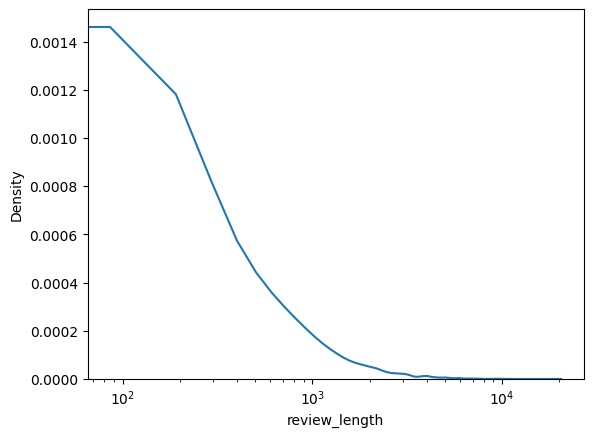

In [46]:
import seaborn as sns


ax = sns.kdeplot(df[df.review_length.isna() == False].review_length)
ax.set_xscale('log')

df.review_length.describe()
df[df.review_length > 20]

## Add headers to CSV files

In [38]:
import glob

lang_files = glob.glob(os.path.join(lang_dir, '*'))
for lang_file in lang_files:
    df = pd.read_csv(lang_file, sep='\t', names=headers, compression='gzip')
    df.to_csv(lang_file, index=False, sep='\t', compression='gzip')